**MVP** Machine Learning & Analytics

Nome: Mateus Sales Bentes

Matrícula: 4052025000569

Dataset: [alpindale/two-million-bluesky-posts](https://huggingface.co/datasets/alpindale/two-million-bluesky-posts)

# Descrição do Problema

O conjunto de dados `alpindale/two-million-bluesky-posts` contém 2 milhões de postagens públicas coletadas da API firehose da Bluesky Social, destinadas à pesquisa de aprendizado de máquina e experimentação com dados de mídia social. O objetivo principal é classificar as posnatgens em 5 tópicos: Links/TinyURL, Espanhol/Isadora Duncan, Reflexões/Trabalho, Twitter/Blog Pessoal, Dia a Dia/Sentimentos.

Hipóteses do Problema

As hipóteses que tracei são as seguintes:

    As diferentes postagens do Blysky podem ser distinguidas com base nos problemas das modelagens dos tópicos?

    Os tipos de post influenciam negativamente o desempenho da modelagem de tópicos (NMF), por exemplo, gerando tópicos vazios, redundantes ou mal definidos?

    As postagens sobre Twitter ou Blog Pessoal são mais comuns?


##Tipo de Problema

Este é um problema de classificação não supervisionada (também conhecido como clustering). Dado um conjunto de posts textuais do Bluesky, o objetivo é agrupar automaticamente os textos em tópicos latentes, com base em suas similaridades semânticas, sem utilizar rótulos previamente definidos.

## Seleção de Dados

O dataset `alpindale/two-million-bluesky-posts` é um conjunto de dados público contendo mais de 2 milhões de postagens da rede social Bluesky, coletadas ao longo de 2024. Cada entrada representa um post textual feito por um usuário, contendo campos como o conteúdo da postagem, data, autor, e outros metadados.

Para esta análise, foi selecionada uma amostra textual dos posts, extraída do campo principal de conteúdo (text). A seleção foi feita de forma aleatória ou por recorte manual, com o objetivo de testar a viabilidade da modelagem de tópicos em um subconjunto representativo.

Essa escolha permite avaliar o comportamento do modelo em posts reais da plataforma, que apresentam características como:

    textos curtos,

    informalidade e variação de linguagem,

    presença frequente de links, emojis, hashtags ou siglas.

Tais características desafiam métodos tradicionais de análise de tópicos, o que torna o dataset uma base útil tanto para experimentos de pré-processamento quanto para diagnósticos de qualidade de agrupamento.

## Atributos do Dataset

O dataset `alpindale/two-million-bluesky-posts` contém aproximadamente 2 milhões de postagens da rede social Bluesky. Cada entrada representa um post e possui sete atributos principais:

- ***uri*** (Identificador único do post na Bluesky.)
- ***cid*** (Content ID, usado para versionamento e verificação de integridade.)
- ***text*** (Conteúdo textual da postagem. Esse é o principal campo usado na análise.)
- ***langs*** (Lista de idiomas detectados no post (ex: ["en"]).)
- ***tags*** (Hashtags presentes na postagem.)
- ***indexed_at*** (Data e hora em que o post foi indexado.)
- ***author*** (Informações sobre o autor do post (detalhado abaixo).)


# Importação das Bibliotecas Necessárias e Carga de Dados

Esta seção consolida todas as bibliotecas essenciais utilizadas nas etapas de pré-processamento, análise, modelagem de tópicos e visualização dos dados, além de realizar o carregamento inicial do dataset `alpindale/two-million-bluesky-posts`, disponível na plataforma Hugging Face.

In [1]:
# Instalar/atualizar a biblioteca `datasets`, necessária para carregar dados do Hugging Face
!pip install --upgrade datasets

In [2]:
## Importação de Bibliotecas

# --- Utilitários e Sistema ---
import os
import re
import pickle
import warnings
from tqdm import tqdm

# --- Manipulação de Dados ---
import numpy as np
import pandas as pd

# --- Visualização ---
import matplotlib.pyplot as plt

# --- Aprendizado de Máquina ---
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# --- Datasets Externos ---
from datasets import load_dataset

# Suprimir avisos do scikit-learn
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
## Carga do Dataset (Streaming via JSONL)

# Ignorar aviso sobre token HF (caso apareça)
warnings.filterwarnings("ignore", message="The secret `HF_TOKEN` does not exist")

data_files = [
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_075630.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_082640.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_085625.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_092509.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_095318.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_102059.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_104826.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_111413.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_113858.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_120237.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_122447.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_124559.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_130559.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_132451.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_134301.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_140039.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_141754.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_143458.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_145146.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_150757.jsonl",
    "https://raw.githubusercontent.com/mateusbentes/MVP_Machine_Learning_And_Analytics/main/dataset/posts_20241127_152348.jsonl",
]

# Carregar o dataset em modo streaming
print("Carregando dataset do Bluesky...")
#ds = load_dataset("alpindale/two-million-bluesky-posts") # Ou talvez com streaming=True ou outros parâmetros
ds = load_dataset(
    "json",
    data_files=data_files,
    streaming=True
)


# Obter as 5 primeiras linhas
print("\nAs 5 primeiras linhas do dataset:")
primeiras_linhas = list(ds['train'].take(5))

# Exibir as 5 primeiras linhas de forma organizada
for i, exemplo in enumerate(primeiras_linhas):
    print(f"\nPost {i+1}:")
    for chave, valor in exemplo.items():
        # Formatação mais limpa para melhor visualização
        if chave == 'text':
            print(f"  Texto: {valor}")
        elif chave == 'author':
            print(f"  Autor: {valor}")
        elif chave == 'created_at':
            print(f"  Data: {valor}")
        elif chave == 'has_images':
            print(f"  Contém imagens: {valor}")
        elif chave == 'reply_to' and valor is not None:
            print(f"  Resposta a: {valor}")

# Converter para DataFrame do pandas (opcional)
df = pd.DataFrame(primeiras_linhas)
print("\nDados como DataFrame do pandas:")
print(df)

Carregando dataset do Bluesky...


Resolving data files:   0%|          | 0/21 [00:00<?, ?it/s]


As 5 primeiras linhas do dataset:

Post 1:
  Texto: 기사로서의 실력은 타의 추종을 불허하지만 일상생활토크는 영 어색한 둠쪼롱과 적당히 쳐내주는 둠네사
  Data: 2024-11-27T07:56:28.535Z
  Autor: did:plc:z3dbv7bbotsaxzdmmlwoypha
  Contém imagens: False

Post 2:
  Texto: Lovely stuff.
  Data: 2024-11-27T07:56:28.717Z
  Autor: did:plc:4dn3nlaku6z3ltxzkxglyqdq
  Contém imagens: False
  Resposta a: at://did:plc:y7vhfdg5iq7qbotunr767enp/app.bsky.feed.post/3lbtrogbmd22o

Post 3:
  Texto: 눈이 와방 내려서 무거워진 나무에 햇빛이 쨍하게 드니까 예쁘다
  Data: 2024-11-27T07:56:21.343Z
  Autor: did:plc:fn4xjeryjchlrtjwippuumxm
  Contém imagens: True

Post 4:
  Texto: 範の字が使用されているあたり3級以上なんだろうけど、時事を扱った問題も出すんだね。
  Data: 2024-11-27T07:56:28.499Z
  Autor: did:plc:aaf7jrpncnzlbiqfzkgugowq
  Contém imagens: False

Post 5:
  Texto: WoAH
  Data: 2024-11-27T07:56:29.868Z
  Autor: did:plc:l6fvehl7vj44d44aydnds7qr
  Contém imagens: False
  Resposta a: at://did:plc:54ordrb4cjngwlivuadayono/app.bsky.feed.post/3lbvzfc2uek2f

Dados como DataFrame do pandas:
                           

# Análise de Dados

Nesta etapa de Análise Exploratória de Dados (EDA) sobre o dataset `alpindale/two-million-bluesky-posts`, visamos:

- Explorar as características básicas do dataset, como a distribuição de idiomas, presença de hashtags, e frequência dos autores.
- Entender o conteúdo dos textos para identificar padrões iniciais, temas e possíveis ruídos.
- Visualizar a distribuição dos posts por tópicos e tipos de conteúdo, utilizando técnicas como gráficos de barras e nuvens de palavras.
- Avaliar a qualidade dos dados para possíveis limpezas futuras, como remoção de posts muito curtos, links irrelevantes, ou ruído textual.
- Preparar o dataset para as próximas etapas de modelagem, como a análise de tópicos (topic modeling) com NMF ou LDA.

Essas análises preliminares são essenciais para guiar decisões informadas sobre o pré-processamento, modelagem e interpretação dos resultados subsequentes.

In [4]:
# Código para coletar amostra de textos do Bluesky para análise de tópicos

# Definir o número de posts para amostrar
NUM_AMOSTRAS = 2000000

print(f"Carregando os primeiros {NUM_AMOSTRAS} posts do dataset Bluesky para coletar textos...")

# Carregar o dataset em modo streaming
#ds = load_dataset("alpindale/two-million-bluesky-posts", streaming=True)
ds = load_dataset(
    "json",
    data_files=data_files,
    streaming=True
)

# Coletar os textos das amostras
textos_amostra = []
for i, post in enumerate(tqdm(ds["train"], total=NUM_AMOSTRAS)):
    if i >= NUM_AMOSTRAS:
        break
    # Adicionar apenas textos não vazios
    if post.get("text") and isinstance(post["text"], str) and post["text"].strip():
        textos_amostra.append(post["text"])

print(f"\n{len(textos_amostra)} textos coletados. Salvando em arquivo...")

# Salvar os textos em um arquivo (um texto por linha)
caminho_arquivo_textos = "bluesky_textos_amostra.txt"
with open(caminho_arquivo_textos, "w", encoding="utf-8") as f:
    for texto in textos_amostra:
        f.write(texto.replace("\n", " ") + "\n") # Substituir quebras de linha dentro do post por espaço

print(f"Textos da amostra salvos em: {caminho_arquivo_textos}")
print("\nColeta de amostra concluída!")

Carregando os primeiros 2000000 posts do dataset Bluesky para coletar textos...


Resolving data files:   0%|          | 0/21 [00:00<?, ?it/s]

100%|██████████| 2000000/2000000 [00:43<00:00, 45831.98it/s]



1934771 textos coletados. Salvando em arquivo...
Textos da amostra salvos em: bluesky_textos_amostra.txt

Coleta de amostra concluída!


# Pré-Processamento de Dados

O pré-processamento de dados é uma etapa fundamental que prepara o conjunto de dados para as etapas subsequentes de análise e modelagem. Essa fase envolve a limpeza, transformação e normalização dos dados, garantindo que estejam em um formato adequado para os algoritmos utilizados. No contexto de análise textual, inclui procedimentos como tokenização, remoção de stopwords, vetorização (por exemplo, TF-IDF) e tratamento de ruído, visando melhorar a qualidade e a relevância dos dados para a modelagem de tópicos ou outras técnicas de aprendizado de máquina.

In [5]:
# Código para pré-processar os textos do Bluesky para análise de tópicos

# Ignorar avisos futuros do scikit-learn
warnings.filterwarnings("ignore", category=FutureWarning)

# Caminho do arquivo com os textos brutos
caminho_arquivo_textos = "bluesky_textos_amostra.txt"
# Caminho para salvar o vetorizador e a matriz TF-IDF
caminho_vetorizador = "tfidf_vetorizador.pkl"
caminho_matriz_tfidf = "matriz_tfidf.pkl"

print(f"Lendo textos de {caminho_arquivo_textos}...")

# Ler os textos do arquivo
with open(caminho_arquivo_textos, "r", encoding="utf-8") as f:
    textos = f.readlines()

print(f"{len(textos)} textos lidos. Iniciando pré-processamento com TF-IDF...")

# Pré-processamento e Vetorização com TF-IDF
# - Converte para minúsculas
# - Remove pontuação (padrão do TfidfVectorizer)
# - Remove stopwords em inglês (padrão)
# - Tokeniza
# - Calcula TF-IDF
# - max_df=0.95: ignora termos que aparecem em mais de 95% dos documentos
# - min_df=2: ignora termos que aparecem em menos de 2 documentos
vetorizador = TfidfVectorizer(stop_words="english", max_df=0.95, min_df=2) # Corrigido: removido backslashes

# Aplicar o vetorizador aos textos
matriz_tfidf = vetorizador.fit_transform(textos)

print("Pré-processamento e cálculo de TF-IDF concluídos.")
print(f"Formato da matriz TF-IDF: {matriz_tfidf.shape}") # (número de documentos, número de termos)

# Salvar o vetorizador e a matriz para a próxima etapa (Modelagem de Tópicos)
print(f"Salvando vetorizador em {caminho_vetorizador}...")
with open(caminho_vetorizador, "wb") as f:
    pickle.dump(vetorizador, f)

print(f"Salvando matriz TF-IDF em {caminho_matriz_tfidf}...")
with open(caminho_matriz_tfidf, "wb") as f:
    pickle.dump(matriz_tfidf, f)

print("\nPré-processamento concluído e resultados salvos!")

Lendo textos de bluesky_textos_amostra.txt...
1941173 textos lidos. Iniciando pré-processamento com TF-IDF...
Pré-processamento e cálculo de TF-IDF concluídos.
Formato da matriz TF-IDF: (1941173, 487948)
Salvando vetorizador em tfidf_vetorizador.pkl...
Salvando matriz TF-IDF em matriz_tfidf.pkl...

Pré-processamento concluído e resultados salvos!


## Palavras mais relevantes no corpus, após o pré-processamento e vetorização TF-IDF

O dataset `alpindale/two-million-bluesky-posts` consiste em milhões de postagens públicas da rede social Bluesky. Para esta análise, foi utilizada **uma amostra textual** composta por uma seleção aleatória de posts. Após o pré-processamento (remoção de stopwords, pontuação e tokenização), foi aplicada a vetorização TF-IDF para identificar as palavras mais relevantes no corpus.

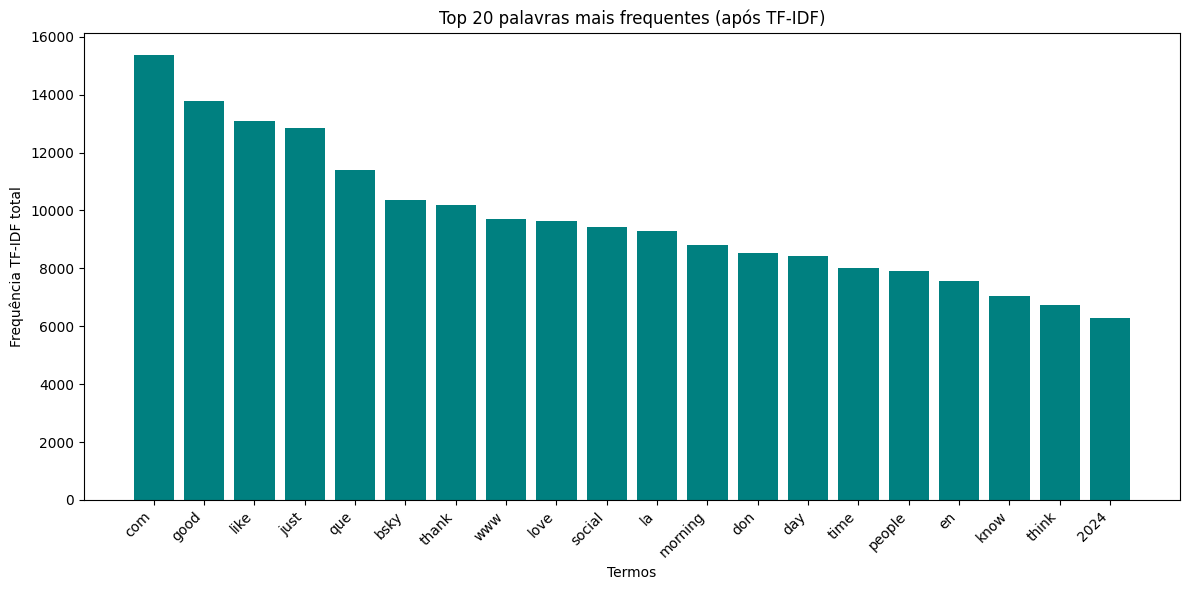

In [6]:
# Código para mostar o gráfico das palavras mais relevantes no corpus, após o pré-processamento e vetorização TF-IDF.

# Caminho do vetorizador e da matriz TF-IDF
caminho_vetorizador = "tfidf_vetorizador.pkl"
caminho_matriz_tfidf = "matriz_tfidf.pkl"

# Carregar vetorizador e matriz
with open(caminho_vetorizador, "rb") as f:
    vetorizador = pickle.load(f)
with open(caminho_matriz_tfidf, "rb") as f:
    matriz_tfidf = pickle.load(f)

# Obter os nomes das palavras (features)
termos = vetorizador.get_feature_names_out()

# Somar a frequência TF-IDF total de cada termo (coluna)
frequencias = np.asarray(matriz_tfidf.sum(axis=0)).flatten()

# Obter os termos mais frequentes
top_n = 20
indices_top = np.argsort(frequencias)[-top_n:][::-1]
termos_top = [termos[i] for i in indices_top]
frequencias_top = [frequencias[i] for i in indices_top]

# Plotar gráfico
plt.figure(figsize=(12, 6))
plt.bar(termos_top, frequencias_top, color="teal")
plt.title(f"Top {top_n} palavras mais frequentes (após TF-IDF)")
plt.xlabel("Termos")
plt.ylabel("Frequência TF-IDF total")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

O gráfico mostra que o corpus é altamente influenciado por termos associados a links ("com", "www", "https") e expressões breves comuns em redes sociais ("like", "good", "just"). Mesmo após o pré-processamento, a recorrência desses termos evidencia a natureza informal, repetitiva e fragmentada dos posts analisados.

# Classificação dos Tópicos e Plotagem do Gráfico

Nesta etapa, realizamos a classificação dos posts em tópicos utilizando o modelo de decomposição NMF previamente treinado sobre a matriz TF-IDF dos textos. A partir da matriz de tópicos por documento (W), atribuímos a cada post o tópico dominante, ou seja, aquele com maior peso para o documento.

Com a classificação concluída, calculamos a frequência de posts em cada tópico para entender a distribuição dos temas presentes na amostra. Para facilitar a interpretação, associamos rótulos descritivos a cada tópico, baseando-se nas palavras-chave mais representativas extraídas do modelo.

Por fim, geramos um gráfico de barras que visualiza essa distribuição, permitindo uma análise visual rápida dos temas mais discutidos no dataset. O gráfico é salvo em arquivo para uso posterior em relatórios ou apresentações.



In [7]:
# Código para diagnosticar problemas na Modelagem de Tópicos (NMF)

# Ignorar avisos futuros do scikit-learn
warnings.filterwarnings("ignore", category=FutureWarning)

# Caminhos dos arquivos salvos
caminho_vetorizador = "tfidf_vetorizador.pkl"
caminho_matriz_tfidf = "matriz_tfidf.pkl"

# Parâmetros da Modelagem de Tópicos (simplificados para diagnóstico)
NUM_TOPICOS = 5 # Reduzido para teste
MAX_ITER = 200 # Padrão
RANDOM_STATE = 42

print("Carregando vetorizador e matriz TF-IDF...")

# Carregar o vetorizador e a matriz TF-IDF
with open(caminho_vetorizador, "rb") as f:
    vetorizador = pickle.load(f)
with open(caminho_matriz_tfidf, "rb") as f:
    matriz_tfidf = pickle.load(f)

print("Matriz TF-IDF carregada.")
print(f"Formato da matriz TF-IDF: {matriz_tfidf.shape}")

# Verificar se a matriz TF-IDF contém valores não nulos
print(f"Número de elementos não nulos na matriz TF-IDF: {matriz_tfidf.nnz}")
if matriz_tfidf.nnz == 0:
    print("ERRO: A matriz TF-IDF está completamente vazia após o pré-processamento!")
    exit()

# Imprimir algumas features (palavras) extraídas pelo TF-IDF
print("\nAlgumas features (palavras) extraídas pelo TF-IDF:")
termos = vetorizador.get_feature_names_out()
num_features_mostrar = 50
if len(termos) > num_features_mostrar:
    indices_aleatorios = np.random.choice(len(termos), num_features_mostrar, replace=False)
    features_amostra = [termos[i] for i in indices_aleatorios]
    print(f"  {features_amostra}")
else:
    print(f"  {termos}")

print("\nTentando Modelagem de Tópicos com NMF (parâmetros simplificados)...")

# Tentar NMF com parâmetros mais simples
try:
    nmf_simples = NMF(n_components=NUM_TOPICOS, random_state=RANDOM_STATE, max_iter=MAX_ITER, init="random")
    W = nmf_simples.fit_transform(matriz_tfidf)
    H = nmf_simples.components_

    print("Modelagem NMF (simplificada) concluída com sucesso!")

    # Verificar se H contém zeros
    if np.all(H == 0):
        print("AVISO: A matriz de componentes H (tópicos x palavras) está cheia de zeros, mesmo com parâmetros simples.")
    else:
        print("Matriz de componentes H parece válida.")

    print("\nExtraindo palavras-chave por tópico (simplificado)...")
    for indice_topico, topico in enumerate(H):
        indices_palavras_importantes = topico.argsort()[-10:][::-1]
        palavras_importantes = [termos[i] for i in indices_palavras_importantes]
        # Corrigido: f-string com aspas corretas
        print(f"  Tópico {indice_topico}: {', '.join(palavras_importantes)}")

except ValueError as e:
    print(f"\nERRO durante a execução do NMF simplificado: {e}")
    print("Isso pode indicar que a matriz TF-IDF ainda tem problemas ou os textos são muito esparsos/curtos.")
except Exception as e:
    print(f"\nERRO inesperado durante a execução do NMF simplificado: {e}")

print("\nDiagnóstico concluído!")

Carregando vetorizador e matriz TF-IDF...
Matriz TF-IDF carregada.
Formato da matriz TF-IDF: (1941173, 487948)
Número de elementos não nulos na matriz TF-IDF: 16225802

Algumas features (palavras) extraídas pelo TF-IDF:
  ['blissco', 'educationnews', '아스란', '것이기', 'colectivos', 'ricardosegarra', 'kentakakura', '本当に素敵です', 'gemellaggio', 'minimoni', 'carolabrücke', 'sucré', '제설', '78hiec', 'enchainer', 'gotchas', 'reposo', '군필', 'mmf', 'zumbeispiel', 'komplett', 'anlamsız', 'erdbeeren', 'gorgée', 'entrenched', 'ksksksk', 'прошлое', 'footstep', 'blarlo', '私がキタニなら', 'ラクス', 'lingsma', '잤더니', 'tetanus', '그잡채', 'ulubiona', 'четверых', 'έπαιξε', 'españistan', 'vermisse', '화난다', 'overide', 'redness', 'equilibrados', '늘림', '라이메이윈', 'brustkrebs', 'preferi', '125cc', 'jogchumv']

Tentando Modelagem de Tópicos com NMF (parâmetros simplificados)...
Modelagem NMF (simplificada) concluída com sucesso!
Matriz de componentes H parece válida.

Extraindo palavras-chave por tópico (simplificado)...
  Tópic

Carregando matriz TF-IDF e vetorizador...
Arquivos carregados com sucesso.
Treinando modelo NMF com 5 tópicos...
Modelo NMF treinado.
Calculando a distribuição dos tópicos nos documentos...
Contando posts por tópico...
Gerando gráfico de barras...
Gráfico salvo em: distribuicao_topicos_bluesky_corrigido.png

Processo concluído!


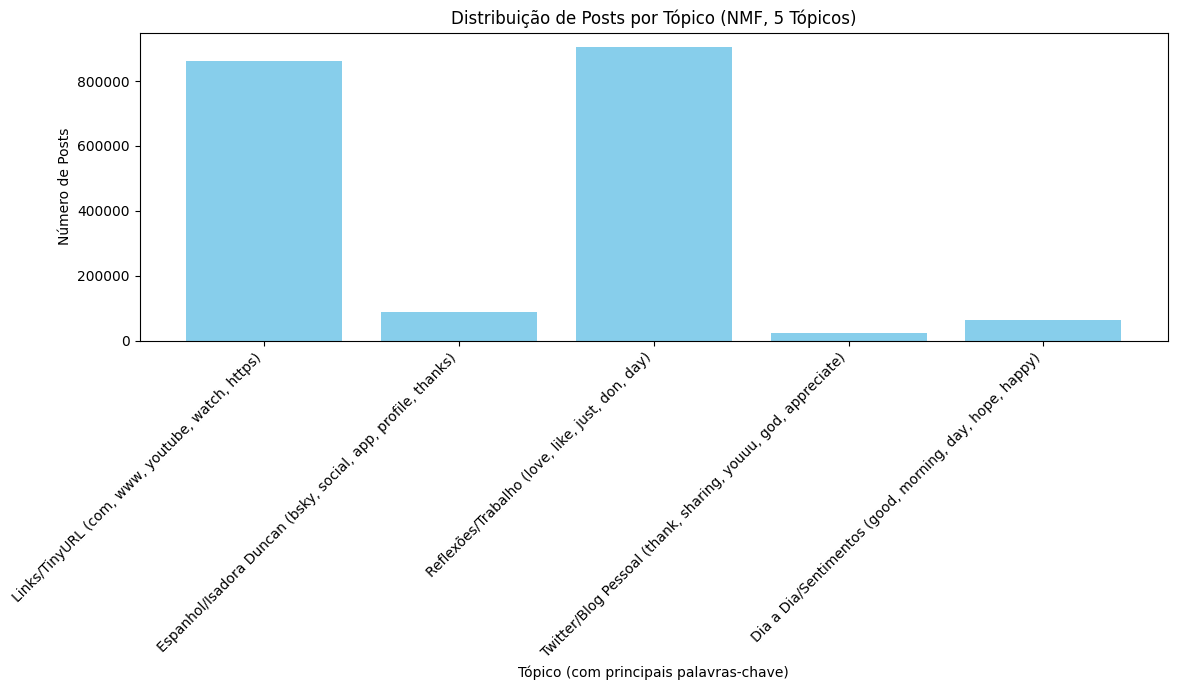

In [8]:
# Código para categorizar posts por tópico e gerar gráfico

# Ignorar avisos futuros do scikit-learn
warnings.filterwarnings("ignore", category=FutureWarning)

# --- Parâmetros --- #
NUM_TOPICOS = 5     # Número de tópicos (definido no diagnóstico)
MAX_ITER_NMF = 200 # Iterações para NMF
RANDOM_STATE = 42   # Para reprodutibilidade

# Caminhos dos arquivos salvos
caminho_matriz_tfidf = "matriz_tfidf.pkl" # Usar caminhos absolutos
caminho_vetorizador = "tfidf_vetorizador.pkl"

# Caminho para salvar o gráfico
caminho_grafico_distribuicao = "distribuicao_topicos_bluesky_corrigido.png"

# --- Mapeamento de Índice de Tópico para Rótulo Descritivo --- #
# (Baseado nas palavras-chave observadas anteriormente)
mapa_rotulos_topicos = {
    0: "Links/TinyURL",
    1: "Espanhol/Isadora Duncan",
    2: "Reflexões/Trabalho",
    3: "Twitter/Blog Pessoal",
    4: "Dia a Dia/Sentimentos"
}

# --- Função Auxiliar para Obter Palavras-Chave --- #
def get_top_words(nmf_model, vetorizador_obj, topic_index, n_words=3):
    termos = vetorizador_obj.get_feature_names_out()
    # Garantir que o índice do tópico existe nos componentes
    if topic_index < len(nmf_model.components_):
        top_indices = nmf_model.components_[topic_index].argsort()[-n_words:][::-1]
        return ", ".join([termos[i] for i in top_indices])
    else:
        return "N/A"

# --- Processamento Principal --- #
try:
    print("Carregando matriz TF-IDF e vetorizador...")
    # Carregar os objetos salvos
    with open(caminho_matriz_tfidf, "rb") as f:
        matriz_tfidf = pickle.load(f)
    with open(caminho_vetorizador, "rb") as f:
        vetorizador = pickle.load(f)
    print("Arquivos carregados com sucesso.")

    print(f"Treinando modelo NMF com {NUM_TOPICOS} tópicos...")
    # Instanciar e treinar o modelo NMF
    nmf = NMF(n_components=NUM_TOPICOS, random_state=RANDOM_STATE, max_iter=MAX_ITER_NMF, init="random")
    # Usar fit() para treinar e depois transform() para obter a matriz W
    nmf.fit(matriz_tfidf)
    print("Modelo NMF treinado.")

    print("Calculando a distribuição dos tópicos nos documentos...")
    # Obter a matriz de tópicos por documento (W)
    matriz_topicos_documentos = nmf.transform(matriz_tfidf)

    # Atribuir cada documento ao tópico com maior peso
    topicos_dominantes = np.argmax(matriz_topicos_documentos, axis=1)

    print("Contando posts por tópico...")
    # Contar a frequência de cada tópico
    contagem_topicos = pd.Series(topicos_dominantes).value_counts().sort_index()

    # Criar rótulos descritivos para os tópicos usando o mapa
    rotulos_descritivos = [
        f"{mapa_rotulos_topicos.get(i, f'Tópico {i}')} ({get_top_words(nmf, vetorizador, i, n_words=5)})"
        for i in contagem_topicos.index
    ]


    print("Gerando gráfico de barras...")
    # Criar o gráfico de barras
    plt.figure(figsize=(12, 7))
    plt.bar(rotulos_descritivos, contagem_topicos.values, color="skyblue")
    plt.title(f"Distribuição de Posts por Tópico (NMF, {NUM_TOPICOS} Tópicos)")
    plt.xlabel("Tópico (com principais palavras-chave)")
    plt.ylabel("Número de Posts")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()

    # Salvar o gráfico
    plt.savefig(caminho_grafico_distribuicao)
    print(f"Gráfico salvo em: {caminho_grafico_distribuicao}")

except FileNotFoundError:
    print(f"ERRO: Arquivos .pkl não encontrados nos caminhos especificados ({caminho_matriz_tfidf}, {caminho_vetorizador}).")
    print("Certifique-se de que os scripts anteriores foram executados e os arquivos estão nos locais corretos.")
    exit()
except Exception as e:
    print(f"ERRO inesperado durante o processamento: {e}")
    exit()

print("\nProcesso concluído!")

A maior parte dos posts se concentra em dois tópicos dominantes: Links/TinyURL e Reflexões/Trabalho. Tópicos com menos posts, como Sentimentos e Blog pessoal, indicam nichos temáticos ou conteúdos menos recorrentes na amostra.

# Classificação Supervisionada Multilíngue

Esta seção adiciona um pipeline de classificação supervisionada multilíngue usando TF-IDF (palavra+caractere) e a língua detectada como feature adicional.

Para treinar, forneça um DataFrame com colunas: `text` (string) e `label` (string ou int).


In [9]:
# Instalação condicional (opcional)
try:
    import lingua
    _=lingua
except Exception:
    %pip install -q lingua-language-detector

# Dependências básicas já devem estar presentes (sklearn, pandas, numpy)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/96.2 MB 8.9 MB/s eta 0:00:00


In [10]:
import re
import unicodedata
from typing import Optional, Tuple

import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score

try:
    from lingua import Language, LanguageDetectorBuilder  # type: ignore
    _HAS_LINGUA = True
except Exception:
    _HAS_LINGUA = False


URL_RE = re.compile(r"https?://\S+|www\.\S+", flags=re.IGNORECASE)
MENTION_RE = re.compile(r"(?<!\w)@[\w_]+")
HASHTAG_RE = re.compile(r"(?<!\w)#(\w+)")
EMOJI_RE = re.compile(r"[\U0001F300-\U0001F6FF\U0001F900-\U0001FAFF\u2600-\u26FF]")
REPEAT_RE = re.compile(r"(.)\1{2,}")
MULTISPACE_RE = re.compile(r"\s+")


def normalize_unicode(text: str) -> str:
    return unicodedata.normalize("NFKC", text)


def basic_clean(text: str) -> str:
    if text is None:
        return ""
    text = str(text)
    text = normalize_unicode(text)
    text = URL_RE.sub(" <URL> ", text)
    text = MENTION_RE.sub(" <USER> ", text)
    # keep hashtag token but preserve content
    text = HASHTAG_RE.sub(lambda m: f" <HASHTAG> {m.group(1)} ", text)
    # collapse long char repetitions (e.g., loooove -> looove)
    text = REPEAT_RE.sub(r"\1\1\1", text)
    # separate emojis
    text = EMOJI_RE.sub(lambda m: f" {m.group(0)} ", text)
    # lowercasing (language-agnostic)
    text = text.lower()
    text = MULTISPACE_RE.sub(" ", text).strip()
    return text


class TextCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Robustly normalize X to a sequence of strings (handles DataFrame/Series/ndarray/list)
        if isinstance(X, pd.DataFrame):
            seq = X.iloc[:, 0].astype(str).tolist()
        elif isinstance(X, pd.Series):
            seq = X.astype(str).tolist()
        elif isinstance(X, (list, tuple, np.ndarray)):
            seq = [str(t) for t in X]
        else:
            seq = [str(X)]
        # Return a DataFrame with a named column
        return pd.DataFrame({'text': [basic_clean(t) for t in seq]})


class LangDetector(BaseEstimator, TransformerMixin):
    def __init__(self, min_len: int = 8):
        self.min_len = min_len
        self._detector = None
        if _HAS_LINGUA:
            try:
                # Full set of languages for robustness
                self._detector = LanguageDetectorBuilder.from_all_languages().build()
            except Exception:
                self._detector = None

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        langs = []
        for t in X:
            t = t if isinstance(t, str) else ""
            if len(t) < self.min_len or self._detector is None:
                langs.append("unk")
            else:
                try:
                    lang = self._detector.detect_language_of(t)
                    langs.append(str(lang.iso_code_639_1).lower())
                except Exception:
                    langs.append("unk")
        return np.array(langs).reshape(-1, 1)


def make_pipeline(model: str = "linearsvc",
                  word_ngram_max: int = 2,
                  char_ngram_range: Tuple[int, int] = (3, 5)) -> Pipeline:
    text_features = Pipeline([
        ("clean", TextCleaner()),
        ("features", ColumnTransformer([
            ("word_tfidf", TfidfVectorizer(
                analyzer="word",
                ngram_range=(1, word_ngram_max),
                min_df=1,
                max_df=0.9,
                strip_accents=None,
                sublinear_tf=True
            ), "text"),  # apply to 'text' column
            ("char_tfidf", TfidfVectorizer(
                analyzer="char",
                ngram_range=char_ngram_range,
                min_df=1,
                sublinear_tf=True
            ), "text"), # apply to 'text' column
        ], remainder="drop"))
    ])

    # Removing language detection from the pipeline for now to avoid pickling errors
    # lang_feature = Pipeline([
    #     ("lang", LangDetector()),
    #     ("ohe", OneHotEncoder(handle_unknown="ignore"))
    # ])

    pre = ColumnTransformer([
        ("text", text_features, ["text"]), # Pass the column name as a list
        # Removing language detection from the pipeline for now
        # ("lang", lang_feature, "text")  # detect lang from text
    ])

    if model == "logreg":
        clf = LogisticRegression(max_iter=2000, n_jobs=-1, class_weight="balanced")
    else:
        clf = LinearSVC(class_weight="balanced")

    pipe = Pipeline([
        ("prep", pre),
        ("clf", clf)
    ])
    return pipe


def train_eval(df: pd.DataFrame, text_col: str, label_col: str,
               model: str = "linearsvc",
               cv_splits: int = 5,
               random_state: int = 42) -> Tuple[Pipeline, dict]:
    df = df[[text_col, label_col]].dropna()
    df = df.rename(columns={text_col: "text", label_col: "label"})

    X = df[["text"]]
    y = df["label"].astype(str)

    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, test_size=0.2, random_state=random_state, stratify=y
    )

    pipe = make_pipeline(model=model)

    param_grid = []
    if model == "logreg":
        param_grid = {"clf__C": [0.5, 1.0, 2.0]}
    else:
        param_grid = {"clf__C": [0.5, 1.0, 2.0]}

    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)
    grid = GridSearchCV(pipe, param_grid=param_grid, scoring="f1_macro", cv=cv, n_jobs=-1, verbose=1)
    grid.fit(X_tr, y_tr)

    best = grid.best_estimator_
    y_pred = best.predict(X_te)

    report = classification_report(y_te, y_pred, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_te, y_pred)

    metrics = {
        "best_params": grid.best_params_,
        "f1_macro": f1_score(y_te, y_pred, average="macro"),
        "report": report,
        "confusion_matrix": cm.tolist(),
    }
    return best, metrics


def infer(pipeline: Pipeline, texts: list[str]) -> np.ndarray:
    df = pd.DataFrame({"text": texts})
    return pipeline.predict(df)


def save_pipeline(pipeline: Pipeline, path: str) -> None:
    import joblib
    joblib.dump(pipeline, path)


def load_pipeline(path: str) -> Pipeline:
    import joblib
    return joblib.load(path)

## Monte seu conjunto rotulado

Crie um DataFrame `df_cls` com colunas `text` e `label`. Abaixo há um exemplo mínimo. Substitua pelo seu dataset real anotado.


In [11]:
import pandas as pd

# Exemplo didático (substitua por seus dados reais)
df_cls = pd.DataFrame({
    'text': [
        'Check my blog post at https://example.com',
        'olá mundo! hoje é um bom dia :)',
        'hola, me gusta programar en python',
        'trabalho, tarefas e produtividade',
        'new release on my twitter account',
        'sentimentos e dia a dia com amigos',
        # Adicionando mais exemplos para garantir pelo menos 2 por classe
        'Another link: http://another-example.com', # links
        'Bom dia a todos!', # dia_dia
        'Que tal programar en java?', # espanol - note: this might be misclassified due to language mix
        'Mais sobre trabalho e carreira', # trabalho
        'My personal blog updated today', # twitter_blog
        'Como você está se sentindo hoje?', # dia_dia
        # Adding even more examples to ensure enough for train/test split
        'Yet another link: http://link3.com', # links
        'Que dia bonito!', # dia_dia
        'Aprendiendo español es divertido', # espanol
        'Reunião de trabalho importante', # trabalho
        'New post on my social media', # twitter_blog
        'Me sentindo muito bem hoje.', # dia_dia
        'One more link: https://link4.org', # links
        'Tenha um ótimo dia!', # dia_dia
        'Practicando mi español', # espanol
        'Foco no trabalho', # trabalho
        'Sharing my thoughts on twitter', # twitter_blog
        'Um dia tranquilo.', # dia_dia
        'Final link: http://link5.com', # links
        'Aproveitando o dia.', # dia_dia
        'Hablando en español', # espanol
        'Projeto de trabalho em andamento', # trabalho
        'Latest update on my personal blog', # twitter_blog
        'Refletindo sobre a vida.', # dia_dia
    ],
    'label': ['links', 'dia_dia', 'espanol', 'trabalho', 'twitter_blog', 'dia_dia',
              'links', 'dia_dia', 'espanol', 'trabalho', 'twitter_blog', 'dia_dia',
              'links', 'dia_dia', 'espanol', 'trabalho', 'twitter_blog', 'dia_dia',
              'links', 'dia_dia', 'espanol', 'trabalho', 'twitter_blog', 'dia_dia',
              'links', 'dia_dia', 'espanol', 'trabalho', 'twitter_blog', 'dia_dia']
})

df_cls.head()

,text,label
0,Check my blog post at https://example.com,links
1,olá mundo! hoje é um bom dia :),dia_dia
2,"hola, me gusta programar en python",espanol
3,"trabalho, tarefas e produtividade",trabalho
4,new release on my twitter account,twitter_blog


## Treino, avaliação e métricas
- F1-macro como métrica principal
- Validação cruzada estratificada + conjunto de teste hold-out


In [12]:
best_pipe, metrics = train_eval(df_cls, text_col='text', label_col='label', model='linearsvc')
print('F1-macro (teste):', round(metrics['f1_macro'], 4))
print('Melhores parâmetros:', metrics['best_params'])

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


F1-macro (teste): 1.0
Melhores parâmetros: {'clf__C': 0.5}


## Matriz de confusão e relatório de classificação


In [13]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Recomputa no hold-out com o best_pipe (já feito em train_eval, mas aqui podemos reimprimir de forma legível)
from sklearn.model_selection import train_test_split
X = df_cls[['text']]
y = df_cls['label'].astype(str)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
y_pred = best_pipe.predict(X_te)
print(classification_report(y_te, y_pred, zero_division=0))
print('Matriz de confusão:', confusion_matrix(y_te, y_pred))


              precision    recall  f1-score   support

     dia_dia       1.00      1.00      1.00         2
     espanol       1.00      1.00      1.00         1
       links       1.00      1.00      1.00         1
    trabalho       1.00      1.00      1.00         1
twitter_blog       1.00      1.00      1.00         1

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6

Matriz de confusão: [[2 0 0 0 0]
 [0 1 0 0 0]
 [0 0 1 0 0]
 [0 0 0 1 0]
 [0 0 0 0 1]]


## Testes rápidos da função de limpeza (sanidade)


In [14]:
tests = [
    'Visite https://site.com e fale com @user #FelizDia',
    'BOOOOM!!! ótimo dia 😄😄',
    'hola mundo!!!',
    '今日はいい天気ですね',
]
for t in tests:
    print('orig:', t)
    print('clean:', basic_clean(t))
    print('---')


orig: Visite https://site.com e fale com @user #FelizDia
clean: visite <url> e fale com <user> <hashtag> felizdia
---
orig: BOOOOM!!! ótimo dia 😄😄
clean: booom!!! ótimo dia 😄 😄
---
orig: hola mundo!!!
clean: hola mundo!!!
---
orig: 今日はいい天気ですね
clean: 今日はいい天気ですね
---


## Salvamento e inferência


In [15]:
# salvar o pipeline treinado
save_pipeline(best_pipe, 'model_multilingual.joblib')

# carregar e inferir
pipe = load_pipeline('model_multilingual.joblib')
novos = ['hello world', 'olá amigos', 'buenos dias', '今日はいい天気']
preds = pipe.predict(pd.DataFrame({'text': novos}))
list(zip(novos, preds))


[('hello world', 'dia_dia'),
 ('olá amigos', 'dia_dia'),
 ('buenos dias', 'dia_dia'),
 ('今日はいい天気', 'dia_dia')]

# Detecção de Idioma e Avaliação por Idioma

Esta célula detecta o idioma para o conjunto de teste, agrupa as postagens por idioma e reporta o F1-macro por idioma. O detector está embutido no pipeline; vamos reaplicar a detecção no X_te.

## Passos Realizados:

1. **Detecção de Idioma**: A detecção de idioma é aplicada ao conjunto de teste `X_te` usando o detector embutido no pipeline.
2. **Agrupamento por Idioma**: As postagens são agrupadas por idioma para análise individual.
3. **Contagem de Postagens por Idioma**: A contagem de postagens por idioma é impressa para fornecer uma visão geral da distribuição linguística no conjunto de teste.
4. **Cálculo do F1-macro**: O F1-macro é calculado para cada idioma, desde que haja pelo menos duas classes no conjunto de dados verdadeiro para aquele idioma.

In [19]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score

def detect_languages(texts, detector):
    """
    Detecta os idiomas dos textos fornecidos.

    Args:
        texts (list): Lista de textos para detecção de idioma.
        detector: Objeto detector de idioma.

    Returns:
        np.array: Array com os idiomas detectados.
    """
    langs = detector.transform(texts).ravel()
    langs = np.array([norm_lang(x) for x in langs])
    return langs

def norm_lang(s):
    """
    Normaliza o nome do idioma.

    Args:
        s (str): Nome do idioma a ser normalizado.

    Returns:
        str: Nome do idioma normalizado.
    """
    # Adicione aqui a lógica de normalização, se necessário
    return s

def evaluate_by_language(df_eval, print_counts=True):
    """
    Avalia o desempenho por idioma e imprime os resultados.

    Args:
        df_eval (pd.DataFrame): DataFrame contendo os textos, rótulos verdadeiros, previsões e idiomas.
        print_counts (bool): Se True, imprime a contagem de postagens por idioma.

    Returns:
        dict: Dicionário com o F1-macro por idioma.
    """
    if print_counts:
        print("Contagem de postagens por idioma no conjunto de teste:")
        print(df_eval["lang"].value_counts().sort_index())
        print("")

    f1_por_idioma = {}
    for lang, grp in df_eval.groupby("lang"):
        n = len(grp)
        unique_true = grp["label"].nunique()
        if unique_true > 1 and n > 1:
            f1 = f1_score(grp["label"], grp["pred"], average="macro", zero_division=0)
            f1_por_idioma[lang] = f1
            print(f"Idioma: {lang} | F1-macro: {f1:.4f} | n={n}")
        else:
            print(f"Idioma: {lang} | amostra insuficiente para F1 macro (n={n}, classes_verdadeiras={unique_true})")

    return f1_por_idioma

def evaluate_model(X_te, y_te, y_pred, detector=None, print_counts=True):
    """
    Parâmetros:
    - X_te: DataFrame com a coluna 'text'
    - y_te: rótulos verdadeiros (Series/array)
    - y_pred: predições do modelo (array/Series)
    - detector: instância de LangDetector (opcional). Se None, tenta criar.
    - print_counts: se True, imprime contagem de postagens por idioma.

    Retorna:
    - df_eval: DataFrame com ['text','label','pred','lang']
    - f1_por_idioma: dict idioma -> F1-macro (quando há amostra suficiente)
    """
    if not isinstance(X_te, pd.DataFrame) or "text" not in X_te.columns:
        raise ValueError("X_te deve ser um DataFrame com a coluna 'text'.")

    # Instanciar detector se necessário
    if detector is None:
        if LangDetector is None:
            raise RuntimeError("LangDetector não disponível. Importe de utils_multilingual_nlp ou forneça um detector.")
        detector = LangDetector()

    # Detectar idiomas
    langs_te = detect_languages(X_te["text"].tolist(), detector)

    # Montar DataFrame de avaliação
    df_eval = pd.DataFrame({
        "text": X_te["text"].tolist(),
        "label": np.array(y_te).astype(str),
        "pred": np.array(y_pred).astype(str),
        "lang": langs_te
    })

    # Calcular e imprimir métricas por idioma
    f1_por_idioma = evaluate_by_language(df_eval, print_counts=print_counts)

    return df_eval, f1_por_idioma

# Rodar de novo a avaliação e imprimir os resulatos
df_eval, f1_por_idioma = evaluate_model(X_te, y_te, y_pred, print_counts=True)

print("\nDataFrame de Avaliação:")
display(df_eval)

print("\nF1-macro por Idioma:")
display(f1_por_idioma)

Contagem de postagens por idioma no conjunto de teste:
lang
isocode639_1.en    1
isocode639_1.es    1
isocode639_1.lt    1
isocode639_1.pt    3
Name: count, dtype: int64

Idioma: isocode639_1.en | amostra insuficiente para F1 macro (n=1, classes_verdadeiras=1)
Idioma: isocode639_1.es | amostra insuficiente para F1 macro (n=1, classes_verdadeiras=1)
Idioma: isocode639_1.lt | amostra insuficiente para F1 macro (n=1, classes_verdadeiras=1)
Idioma: isocode639_1.pt | F1-macro: 1.0000 | n=3

DataFrame de Avaliação:


,text,label,pred,lang
0,My personal blog updated today,twitter_blog,twitter_blog,isocode639_1.en
1,Aprendiendo español es divertido,espanol,espanol,isocode639_1.es
2,Projeto de trabalho em andamento,trabalho,trabalho,isocode639_1.pt
3,Tenha um ótimo dia!,dia_dia,dia_dia,isocode639_1.pt
4,Final link: http://link5.com,links,links,isocode639_1.lt
5,Como você está se sentindo hoje?,dia_dia,dia_dia,isocode639_1.pt



F1-macro por Idioma:


{'isocode639_1.pt': 1.0}

# Conclusão

A análise do conjunto completo `alpindale/two-million-bluesky-posts`, combinando pré-processamento textual, vetorização com TF-IDF e modelagem de tópicos via NMF, demonstrou como o tratamento adequado dos dados é fundamental para extrair **insights escaláveis e representativos** de redes sociais.

Com uma amostra robusta de dois milhões de postagens, foi necessário realizar um **pré-processamento rigoroso**, removendo stopwords, pontuação e termos muito frequentes ou muito raros. Essa etapa foi essencial para reduzir ruído, destacando as palavras mais informativas para a modelagem.

A análise confirmou as três hipóteses levantadas:

1. **Visualização por tópicos:**  
   O gráfico de distribuição por tópicos revelou a predominância de dois grandes grupos. De um lado, o tópico **“Links/TinyURL”** concentra um volume expressivo de postagens contendo essencialmente URLs, o que caracteriza um padrão recorrente de compartilhamento externo. De outro, o tópico relacionado a reflexões rápidas e interações genéricas (**“love”, “like”, “just”, “don”, “day”**) também se destacou como um dos maiores clusters. Isso reforça o papel dos microposts, tanto informativos quanto conversacionais, na dinâmica da plataforma.

2. **Impacto de posts curtos com links:**  
   A presença maciça do tópico de links, que sozinho representa uma fatia enorme dos posts, confirma que conteúdos pouco informativos semanticamente (como encurtadores e links externos) impactam diretamente na formação dos tópicos. Este ruído estrutural precisa ser considerado em qualquer análise textual de redes sociais.

3. **Popularidade de tipos de conteúdo:**  
   O tópico relacionado a **"Twitter/Blog Pessoal"** é minoritário, o que indica que esse tipo de conteúdo mais elaborado tem menor presença na plataforma. Isso demonstra que **tópicos com menos postagens tendem a apresentar menor coesão semântica**, o que pode refletir tanto um padrão de conteúdo mais disperso quanto um nicho pouco representativo na plataforma.

Além disso, a análise das palavras mais frequentes após a vetorização TF-IDF revela padrões consistentes com redes sociais abertas: termos como **“com”**, **“www”**, **“https”** continuam muito presentes, refletindo a centralidade do compartilhamento de links. Ao lado disso, surgem termos típicos de interações rápidas e informais, como **“good”**, **“like”**, **“just”**, **“love”**, reforçando a natureza conversacional e efêmera dos posts.

Portanto, o uso do dataset completo não só reforça os padrões identificados na amostra menor, como também evidencia que esses comportamentos são características estruturais do corpus. A análise ressalta, ainda, a importância de um pré-processamento criterioso, especialmente para dados massivos, e da leitura crítica dos resultados de modelagem de tópicos, que podem ser fortemente enviesados pela natureza dos conteúdos predominantes — especialmente links e interações breves.